# Chapter 4: Influential Classification Tools - Transfer Learning with Keras

In this last notebook covering Chapter 4, we will demonstrate how transfer learning can be achieved with Keras. More precisely, we will present how Keras Applications pre-trained on rich datasets can be reused for new tasks. Unlike Notebook [4-3](./ch4_notebook_3_resnet_from_keras_app.ipynb) where we instantiated a ResNet-50 from Keras-App with random parameters, we will this time ask Keras to fetch for us the parameters pre-trained on ImageNet. This will give us the opportunity to test different types of transfer learning; i.e. **_freezing_** or **_fine-tuning_** the feature-extractor layers.

In [1]:
import tensorflow as tf
import os
from matplotlib import pyplot as plt

In [2]:
from tiny_imagenet import (
    tiny_imagenet, _training_augmentation_fn, 
    IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, NUM_CLASSES)

TINY_IMAGENET_ROOT_FOLDER = os.path.expanduser('~/datasets/tiny-imagenet-200/')

NUM_TRAINING_IMAGES = 500 * NUM_CLASSES
NUM_VAL_IMAGES = 50 * NUM_CLASSES
batch_size = 32
num_epochs = 30

train_steps_per_epoch = NUM_TRAINING_IMAGES // batch_size
val_steps_per_epoch = NUM_VAL_IMAGES // batch_size

# Like in previous notebooks, we actually resize the Tiny-ImageNet images to ImageNet commonly-used dimensions:
IMG_HEIGHT, IMG_WIDTH = 224, 224

## ResNet with Frozen Feature Extractor

In this first section, we will use the ResNet-50 from Keras Application, pre-trained on ImageNet, as a feature extractor, and build a new classifier for Tiny-ImageNet on top (c.f. Chapter 4). We will then illustrate the first transfer learning use-case presented in the book, i.e., completely freezing the feature extractor and only training the new dense layers on top.

### Building a New Classifier from Pre-trained Keras Applications

We first build our model, a ResNet-50 solution to predict from the 200 classes of Tiny-ImageNet.

To do so, we first use Keras Applications to instantiate a network with pre-trained weights, but without any top layers (i.e., without the final dense layers leading to predictions):

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

resnet50_feature_extractor = tf.keras.applications.resnet50.ResNet50(
    include_top=False, weights='imagenet', 
    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
# resnet50_feature_extractor.summary()

/home/benjamin/anaconda3/envs/main/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


As mentioned earler, we then _freeze_ this feature extractor; i.e., we make the layers of this network non-trainable, as we want to preserve the knowledge this ResNet obtained by being trained on ImageNet, a much richer dataset.

However, while we want to preserve the feature-extracting layers (i.e., the convolutional layers making most of ResNet), **we should be careful not to freeze some other layers like the regularization ones**. Layers like the _batch-normalization_ ones (added after most of the convolutions in ResNet architectures) have some trainable parameters (c.f. Chapter 3) which tend to become too dataset-specific. It is often recommended not to freeze such layers and let them adapt to the new task/dataset. Therefore, we check the layers' type before freezing them or not:

In [4]:
frozen_layers, trainable_layers = [], []
for layer in resnet50_feature_extractor.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        layer.trainable = False
        frozen_layers.append(layer.name)
    else:
        if len(layer.trainable_weights) > 0:
            # We list as "trainable" only the layers with trainable parameters.
            trainable_layers.append(layer.name)

In [5]:
log_begin_red, log_begin_blue, log_begin_green = '\033[91m', '\n\033[94m', '\033[92m'
log_begin_bold, log_begin_underline = '\033[1m', '\033[4m'
log_end_format = '\033[0m'

# Logging the lists of frozen/trainable layers:
print("{2}Layers we froze:{4} {0} ({3}total = {1}{4}).".format(
    frozen_layers, len(frozen_layers), log_begin_red, log_begin_bold, log_end_format))
print("\n{2}Layers which will be fine-tuned:{4} {0} ({3}total = {1}{4}).".format(
    trainable_layers, len(trainable_layers), log_begin_blue, log_begin_bold, log_end_format))

Layers we froze: ['conv1', 'res2a_branch2a', 'res2a_branch2b', 'res2a_branch2c', 'res2a_branch1', 'res2b_branch2a', 'res2b_branch2b', 'res2b_branch2c', 'res2c_branch2a', 'res2c_branch2b', 'res2c_branch2c', 'res3a_branch2a', 'res3a_branch2b', 'res3a_branch2c', 'res3a_branch1', 'res3b_branch2a', 'res3b_branch2b', 'res3b_branch2c', 'res3c_branch2a', 'res3c_branch2b', 'res3c_branch2c', 'res3d_branch2a', 'res3d_branch2b', 'res3d_branch2c', 'res4a_branch2a', 'res4a_branch2b', 'res4a_branch2c', 'res4a_branch1', 'res4b_branch2a', 'res4b_branch2b', 'res4b_branch2c', 'res4c_branch2a', 'res4c_branch2b', 'res4c_branch2c', 'res4d_branch2a', 'res4d_branch2b', 'res4d_branch2c', 'res4e_branch2a', 'res4e_branch2b', 'res4e_branch2c', 'res4f_branch2a', 'res4f_branch2b', 'res4f_branch2c', 'res5a_branch2a', 'res5a_branch2b', 'res5a_branch2c', 'res5a_branch1', 'res5b_branch2a', 'res5b_branch2b', 'res5b_branch2c', 'res5c_branch2a', 'res5c_branch2b', 'res5c_branch2c'] (total = 53).


Layers which will be fine

We now add on top of this network the trainable layers to make predictions from the features:

In [6]:
features = resnet50_feature_extractor.output
avg_pool = GlobalAveragePooling2D(data_format='channels_last')(features)
predictions = Dense(NUM_CLASSES, activation='softmax')(avg_pool)

resnet50_freeze = Model(resnet50_feature_extractor.input, predictions)

### Preparing the Data

Once again, we reuse the functions we implemented in a previous [notebook](./ch4_notebook_1_data_preparation.ipynb) to set up the input pipelines:

In [7]:
train_images, train_labels, class_ids, class_readable_labels = tiny_imagenet(
    phase='train', shuffle=True, batch_size=batch_size, num_epochs=num_epochs, wrap_for_estimator=False,
    augmentation_fn=_training_augmentation_fn, root_folder=TINY_IMAGENET_ROOT_FOLDER,
    resize_to=[IMG_HEIGHT, IMG_WIDTH])

val_images, val_labels, _, _ = tiny_imagenet(
    phase='val', shuffle=False, batch_size=batch_size, num_epochs=None, wrap_for_estimator=False,
    augmentation_fn=None, root_folder=TINY_IMAGENET_ROOT_FOLDER,
    resize_to=[IMG_HEIGHT, IMG_WIDTH])

### Training the Network

Similarly, the training script itself is purely copy-pasted from previous notebooks (we invite our readers to check them if details are needed). Indeed, with the loading of the pre-trained weights and the freezing of the desired layers already covered, the resulting model can be trained like any others:

In [8]:
import functools

sparse_top_5_categorical_accuracy = functools.partial(
    tf.keras.metrics.sparse_top_k_categorical_accuracy, k=5)
sparse_top_5_categorical_accuracy.__name__ = 'sparse_top_5_categorical_accuracy'

optimizer = tf.keras.optimizers.SGD(momentum=0.9, nesterov=True)

model_dir = './models/resnet_keras_app_freeze_all'
callbacks = [
    # Callback to interrupt the training if the validation loss/metrics stops improving for some epochs:
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_sparse_categorical_accuracy'),
    # Callback to log the graph, losses and metrics into TensorBoard:
    tf.keras.callbacks.TensorBoard(log_dir=model_dir, histogram_freq=0, write_graph=True),
    # Callback to save the model (e.g., every 5 epochs), specifying the epoch and val-loss in the filename:
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(model_dir, 'weights-epoch{epoch:02d}-loss{val_loss:.2f}.h5'), period=5)
]


resnet50_freeze.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', 
                 metrics=['sparse_categorical_accuracy', sparse_top_5_categorical_accuracy])
history_freeze = resnet50_freeze.fit(
    train_images, train_labels,  epochs=num_epochs, steps_per_epoch=train_steps_per_epoch,
    validation_data=(val_images, val_labels), validation_steps=val_steps_per_epoch,
    verbose=1, callbacks=callbacks)

Epoch 1/30
3125/3125 [==============================] - 598s 191ms/step - loss: 1.5406 - sparse_categorical_accuracy: 0.6230 - sparse_top_5_categorical_accuracy: 0.8423 - val_loss: 1.1648 - val_sparse_categorical_accuracy: 0.7028 - val_sparse_top_5_categorical_accuracy: 0.8983
Epoch 2/30
3125/3125 [==============================] - 591s 189ms/step - loss: 0.9002 - sparse_categorical_accuracy: 0.7584 - sparse_top_5_categorical_accuracy: 0.9286 - val_loss: 1.0888 - val_sparse_categorical_accuracy: 0.7237 - val_sparse_top_5_categorical_accuracy: 0.9076
Epoch 3/30
3125/3125 [==============================] - 591s 189ms/step - loss: 0.7304 - sparse_categorical_accuracy: 0.7982 - sparse_top_5_categorical_accuracy: 0.9486 - val_loss: 1.0564 - val_sparse_categorical_accuracy: 0.7342 - val_sparse_top_5_categorical_accuracy: 0.9143
Epoch 4/30
3125/3125 [==============================] - 592s 189ms/step - loss: 0.6269 - sparse_categorical_accuracy: 0.8221 - sparse_top_5_categorical_accuracy: 0.96

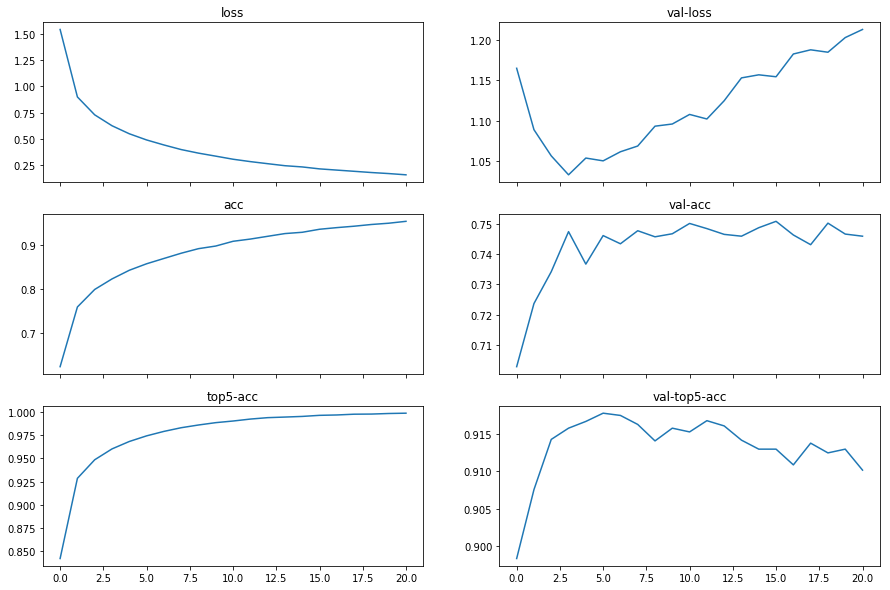

In [9]:
fig, ax = plt.subplots(3, 2, figsize=(15, 10), sharex='col')
ax[0, 0].set_title("loss")
ax[0, 1].set_title("val-loss")
ax[1, 0].set_title("acc")
ax[1, 1].set_title("val-acc")
ax[2, 0].set_title("top5-acc")
ax[2, 1].set_title("val-top5-acc")

ax[0, 0].plot(history_freeze.history['loss'])
ax[0, 1].plot(history_freeze.history['val_loss'])
ax[1, 0].plot(history_freeze.history['sparse_categorical_accuracy'])
ax[1, 1].plot(history_freeze.history['val_sparse_categorical_accuracy'])
ax[2, 0].plot(history_freeze.history['sparse_top_5_categorical_accuracy'])
ax[2, 1].plot(history_freeze.history['val_sparse_top_5_categorical_accuracy'])

Carefully freezing the feature extractor, we achieved a new high in terms of accuracy! With ~75% top-1 / ~92% top-5 accuracy, we are now far from the original ~37% top-1 / ~64% top-5 accuracy obtained with the same model, without transfer learning.

## ResNet with Fine-tuned Feature Extractor

In the following section, we will define the exact same ResNet-50 network with pre-trained layers. However this time, we will not completely freeze its feature-extractor component, in order to _fine-tune_ the latest, higher-level convolutional layers. As we explained in Chapter 4, this fine-tuning can benefit the new classifier which may learn to extract more task-relevant features _(fine-tuning is recommend only if the training dataset is big enough to avoid over-fitting)_.

### Selectively Freezing Layers

The idea this time is to fix the weights of some of the first layers, and retrain all the others. For instance, the code below demonstrates how we could fix the weights of the 3 first _macro-blocks_ only (see Notebook [4-2](./ch4_notebook_2_resnet_from_scratch.ipynb) for definition of "_macro-block_") and fine-tune the remaining one while training the new final layers.

In [10]:
for layer in resnet50_feature_extractor.layers:
    if 'res5' in layer.name:
        # Keras developers named the layers in their ResNet implementation to explicitly 
        # identify which macro-block and block each layer belongs to.
        # If we reach a layer which has a name starting by 'resnet5', it means we reached 
        # the 4th macro-block / we are done with the 3rd one (see layer names listed previously):
        break
    if isinstance(layer, tf.keras.layers.Conv2D):
        layer.trainable = False

### Meta-Iterating to Find the Best Transfer Learning Solution

Note that in practice, **deciding which layers to fine-tune or not may require several trainings** to compare the performance of the corresponding models. This is what we will try in this section.

We will test different macro-configurations, freezing a variable number of layers and evaluating the performance of the resulting network during training. In this example, we will try freezing from 0 to all the four macro-blocks of the ResNet feature-extractor.

_Warning_: these 4 consecutive trainings may take days. In practice, it would be recommended for instance to run them in parallel. Note that thanks to the `ModelCheckpoint()` callback, it is however possible to restore models if the trainings are interrupted (adding the line `resnet50_finetune.load_weights(filename_latest_checkpoint)` before launching the training again. Note also that we are turning off the Keras logs this time, to keep the notebook readable.

In [16]:
num_macroblocks_to_freeze = [0, 1, 2, 3] # we already covered the "all 4 frozen" case above.

histories = dict()
histories['freeze all'] = history_freeze
for freeze_num in num_macroblocks_to_freeze:
        
    print("{1}{2}>> {3}ResNet-50 with {0} macro-block(s) frozen{4}:".format(
        freeze_num, log_begin_green, log_begin_bold, log_begin_underline, log_end_format))
    
    # ---------------------
    # 1. We instantiate a new classifier each time:
    resnet50_feature_extractor = tf.keras.applications.resnet50.ResNet50(
        include_top=False, weights='imagenet', 
        input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), classes=NUM_CLASSES)

    features = resnet50_feature_extractor.output
    avg_pool = GlobalAveragePooling2D(data_format='channels_last')(features)
    predictions = Dense(NUM_CLASSES, activation='softmax')(avg_pool)

    resnet50_finetune = Model(resnet50_feature_extractor.input, predictions)
    
    # ---------------------
    # 2. We freeze the desired layers: 
    break_layer_name = 'res{}'.format(freeze_num + 2) if freeze_num > 0 else 'conv1'
    frozen_layers = []
    for layer in resnet50_finetune.layers:
        if break_layer_name in layer.name:
            break
        if isinstance(layer, tf.keras.layers.Conv2D):
            # If the layer is a convolution, and isn't after the 1st layer not to train:
            layer.trainable = False
            frozen_layers.append(layer.name)
    
    print("\t> {2}Layers we froze:{4} {0} ({3}total = {1}{4}).".format(
        frozen_layers, len(frozen_layers), log_begin_red, log_begin_bold, log_end_format))
    
    # ---------------------
    # 3. To start from the beginning the data iteration, 
    #    we re-instantiate the input pipelines (same parameters):
    train_images, train_labels, _, _ = tiny_imagenet(
        phase='train', shuffle=True, batch_size=batch_size, num_epochs=num_epochs, 
        wrap_for_estimator=False, augmentation_fn=_training_augmentation_fn, 
        root_folder=TINY_IMAGENET_ROOT_FOLDER, resize_to=[IMG_HEIGHT, IMG_WIDTH])

    val_images, val_labels, _, _ = tiny_imagenet(
        phase='val', shuffle=False, batch_size=batch_size, num_epochs=None, 
        wrap_for_estimator=False, augmentation_fn=None, 
        root_folder=TINY_IMAGENET_ROOT_FOLDER, resize_to=[IMG_HEIGHT, IMG_WIDTH])

    # ---------------------
    # 4. We set up the training operations, and start the process:
    # We set a smaller learning rate for the fine-tuning:
    # optimizer = tf.keras.optimizers.SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True)
    optimizer = tf.keras.optimizers.SGD(momentum=0.9, nesterov=True)

    model_dir = './models/resnet_keras_app_freeze_{}_mb'.format(freeze_num)
    callbacks = [
        # Callback to interrupt the training if the validation loss/metrics converged:
        # (we use a shorter patience here, just to shorten a bit the demonstration, already quite long...)
        tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_sparse_categorical_accuracy'),
        # Callback to log the graph, losses and metrics into TensorBoard:
        tf.keras.callbacks.TensorBoard(log_dir=model_dir, histogram_freq=0, write_graph=True),
        # Callback to save the model (e.g., every 5 epochs)::
        tf.keras.callbacks.ModelCheckpoint(
            os.path.join(model_dir, 'weights-epoch{epoch:02d}-loss{val_loss:.2f}.h5'), period=5)
    ]

    resnet50_finetune.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', 
                              metrics=['sparse_categorical_accuracy', sparse_top_5_categorical_accuracy])

    print("\t> Training - {0}start{1} (logs = off)".format(log_begin_red, log_end_format))
    history = resnet50_finetune.fit(
        train_images, train_labels, epochs=num_epochs, steps_per_epoch=train_steps_per_epoch,
        validation_data=(val_images, val_labels), validation_steps=val_steps_per_epoch,
        verbose=0, callbacks=callbacks)
    print("\t> Training - {0}over{1}".format(log_begin_green, log_end_format))

    acc = history.history['sparse_categorical_accuracy'][-1] * 100
    top5 = history.history['sparse_top_5_categorical_accuracy'][-1] * 100
    val_acc = history.history['val_sparse_categorical_accuracy'][-1] * 100
    val_top5 = history.history['val_sparse_top_5_categorical_accuracy'][-1] * 100
    epochs = len(history.history['val_loss'])
    print("\t> Results after {5}{0}{6} epochs:\t{5}acc = {1:.2f}%; top5 = {2:.2f}%; val_acc = {3:.2f}%; val_top5 = {4:.2f}%{6}".format(
        epochs, acc, top5, val_acc, val_top5, log_begin_bold, log_end_format))

    histories['freeze {}'.format(freeze_num)] = history

>> ResNet-50 with 0 macro-block(s) frozen:
	> Layers we froze: [] (total = 0).
	> Training - start (logs = off)
	> Training - over
	> Results after 25 epochs:	acc = 99.96%; top5 = 100.00%; val_acc = 70.46%; val_top5 = 88.48%
>> ResNet-50 with 1 macro-block(s) frozen:
	> Layers we froze: ['conv1', 'res2a_branch2a', 'res2a_branch2b', 'res2a_branch2c', 'res2a_branch1', 'res2b_branch2a', 'res2b_branch2b', 'res2b_branch2c', 'res2c_branch2a', 'res2c_branch2b', 'res2c_branch2c'] (total = 11).
	> Training - start (logs = off)
	> Training - over
	> Results after 25 epochs:	acc = 99.97%; top5 = 100.00%; val_acc = 70.29%; val_top5 = 88.72%
>> ResNet-50 with 2 macro-block(s) frozen:
	> Layers we froze: ['conv1', 'res2a_branch2a', 'res2a_branch2b', 'res2a_branch2c', 'res2a_branch1', 'res2b_branch2a', 'res2b_branch2b', 'res2b_branch2c', 'res2c_branch2a', 'res2c_branch2b', 'res2c_branch2c', 'res3a_branch2a', 'res3a_branch2b', 'res3a_branch2c', 'res3a_branch1', 'res3b_branch2a', 'res3b_branch2b', 'res

Once again (c.f. previous notebooks), the callbacks we defined allow us to follow the trainings in Tensorboard:

![Tensorboard Screenshot](./notebook_images/transfer_learning_training.png)

Once the trainings over,we call also use the `history` objects, e.g., to plot the training results ourselves, or compute some statistics:

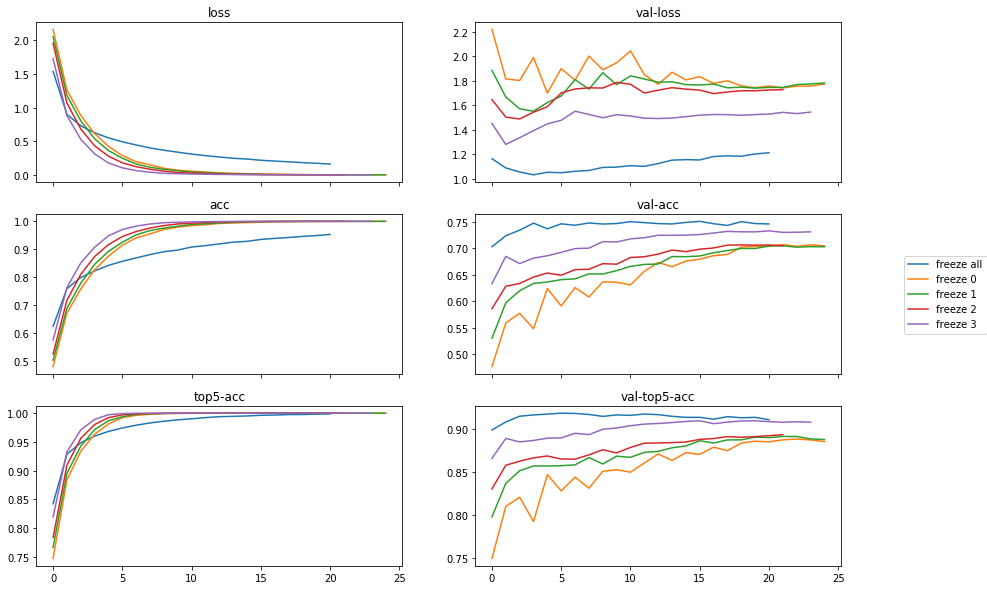

In [19]:
fig, ax = plt.subplots(3, 2, figsize=(15, 10), sharex='col') # add parameter `sharey='row'` for a more direct comparison
ax[0, 0].set_title("loss")
ax[0, 1].set_title("val-loss")
ax[1, 0].set_title("acc")
ax[1, 1].set_title("val-acc")
ax[2, 0].set_title("top5-acc")
ax[2, 1].set_title("val-top5-acc")

lines, labels = [], []
for config_name in histories:
    history = histories[config_name]
    ax[0, 0].plot(history.history['loss'])
    ax[0, 1].plot(history.history['val_loss'])
    ax[1, 0].plot(history.history['sparse_categorical_accuracy'])
    ax[1, 1].plot(history.history['val_sparse_categorical_accuracy'])
    ax[2, 0].plot(history.history['sparse_top_5_categorical_accuracy'])
    line = ax[2, 1].plot(history.history['val_sparse_top_5_categorical_accuracy'])
    lines.append(line[0])
    labels.append(config_name)

fig.legend(lines, labels, loc='center right', borderaxespad=0.1)
plt.subplots_adjust(right=0.87)

While most of our ResNet-50 instances are converging as fast in terms of training losses/metrics, we can observe some strong discrepancies regarding the validation results. We can directly observe that for this experiment on Tiny-ImageNet, the more layers we freeze in the ImageNet-trained feature-extractor, the better the validation accuracy. With its feature-extractor completely frozen, the model we trained in the first part of this notebook not only reached high-validation results much faster, but it also beat all the other instances for this experiment. Interestingly, its accuracy on the training data is however not as good as those of the fine-tuned models, though those models clearly do not perform as well on unseen images. This indicates our fine-tuned models may **over-fit** the training sets a bit.

Indeed, this experiment is a **typical example of the first transfer learning case** we introduced in Chapter 4 (c.f. book). Tiny-ImageNet is a small dataset, highly similar to the ImageNet dataset the Keras official models were trained on (as its name implies, Tiny-ImageNet is a _tiny_ subset of ImageNet). Hence the really good results when directly reusing these models as feature extractors.

There is another interesting observation we can make from the results above. If we compare the accuracy of the ResNet-50 model we completely fine-tuned ("_freeze 0_") to the accuracy of the exact same model we trained from scratch in a [previous notebook](./ch4_notebook_3_resnet_from_keras_app.ipynb), the difference is really clear. By **instantiating our networks with pre-trained weights instead of random ones**, we boosted the performance of our model (c.f. Chapter 4; the boost is really clear here, since the original and target tasks are highly similar).

Finally, it may be frustrating to have trained all these additional models for apparently nothing, as none beat our first attempt in this notebook. In practice, **it is however common to train several instances of a model with different hyper-parameters**, in order to find the best configuration. It is a time-consuming and heavy task, but necessary when high performance is a key factor.

## Visual Results

For the sake of concluding the last notebook dedicated to Chapter 4 with some visual results, we will reuse the code introduced in a [previous notebook](./ch4_notebook_3_resnet_from_keras_app.ipynb), to display some predictions on the test data:

In [20]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import glob
import matplotlib.gridspec as gridspec

def load_image(image_path, size):
    """
    Load an image as a Numpy array.
    :param image_path:  Path of the image
    :param size:        Target size
    :return             Image array, normalized between 0 and 1
    """
    return img_to_array(load_img(image_path, target_size=size)) / 255.


def process_predictions(class_probabilities, class_ids, class_readable_labels, k=5):
    """
    Process a batch of predictions from our estimator.
    :param class_probabilities:     Prediction results returned by the Keras classifier for a batch of data
    :param class_ids:               Class IDs to recover predicted labels
    :param class_readable_labels:   Dictionary of readable-class labels, for display
    :param k:                       Number of top predictions to consider
    :return                         Readable labels and probabilities for the predicted classes
    """
    
    topk_labels, topk_probabilities = [], []
    for i in range(len(class_probabilities)):
        # Getting the top-k predictions:
        topk_classes = sorted(np.argpartition(class_probabilities[i], -k)[-k:])
    
        # Getting the corresponding labels and probabilities:
        topk_labels.append([class_readable_labels[class_ids[predicted]] for predicted in topk_classes])
        topk_probabilities.append(class_probabilities[i][topk_classes])
    
    return topk_labels, topk_probabilities


def display_predictions(images, topk_labels, topk_probabilities):
    """
    Plot a batch of predictions.
    :param images:                  Batch of input images
    :param topk_labels:             String labels of predicted classes
    :param topk_probabilities:      Probabilities for each class
    """
    num_images = len(images)
    num_images_sqrt = np.sqrt(num_images)
    plot_cols = plot_rows = int(np.ceil(num_images_sqrt))
    
    figure = plt.figure(figsize=(13,10))
    grid_spec = gridspec.GridSpec(plot_cols, plot_rows)
    
    for i in range(num_images):
        img, pred_labels, pred_proba = images[i], topk_labels[i], topk_probabilities[i]
        # Shortening the labels to better fit in the plot:
        pred_labels = [label.split(',')[0][:20] for label in pred_labels]
        
        grid_spec_i = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=grid_spec[i], hspace=0)
        
        # Drawing the input image:
        ax_img = figure.add_subplot(grid_spec_i[0])
        ax_img.imshow(img)
        
        # Plotting a bar chart for the predictions:
        ax_pred = figure.add_subplot(grid_spec_i[1])
        y_pos = np.arange(len(pred_labels))
        ax_pred.barh(y_pos, pred_proba, align='center')
        ax_pred.set_yticks(y_pos)
        ax_pred.set_yticklabels(pred_labels)
        ax_pred.invert_yaxis()
        
    plt.tight_layout()
    plt.show()

In [21]:
test_filenames = glob.glob(os.path.join(TINY_IMAGENET_ROOT_FOLDER, 'test', 'images', '*'))
test_images = np.asarray([load_image(file, size=(IMG_HEIGHT, IMG_WIDTH)) for file in test_filenames])
print('Test Images: {}'.format(test_images.shape))

Test Images: (10000, 224, 224, 3)


Predicted class probabilities: (16, 200)


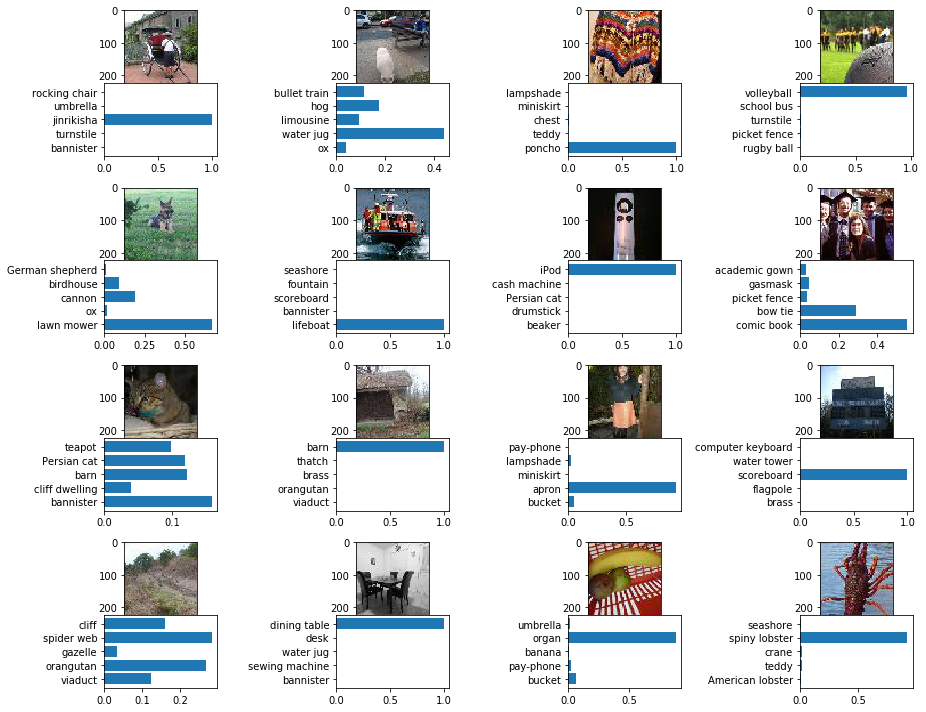

In [24]:
random_image_indices = np.random.choice(len(test_images), size=16)
image_batch = test_images[random_image_indices]
predictions = resnet50_freeze.predict_on_batch(image_batch)
print('Predicted class probabilities: {}'.format(predictions.shape))

top5_labels, top5_probabilities = process_predictions(predictions, class_ids, class_readable_labels)
    
display_predictions(image_batch, top5_labels, top5_probabilities)

With this, we are done with Chapter 4. Through these five notebooks, we experimented with some state-of-the-art CNNs, even re-implemented the ResNet architecture by ourselves, and finally harnested the power of transfer learning. With these tools, we are now well-equiped to solve complex classification problems.

In the next chapters, we will transfer this knowledge to various tasks, like object detection, semantic segmentation, etc.